## 【目次】 自己相関係数、偏自己相関係数まとめ
### 1. 　AR(1)で自己相関、偏自己相関を計算してみる。
### 2. 　時系列データ分析のデータを使って計算してみる。（未）

## 1. AR(1)の自己相関、偏自己相関を計算してみる

### https://stats.biopapyrus.jp/time-series/acf.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

### 1.1 テストデータの作成

$\ Y_t = \phi_0 + \phi_1Y_{t-1} + \epsilon_t$
($\epsilon_t,\epsilon_{t-1},\cdots ,\epsilon_0$は独立で、$\epsilon_u ～ N(0,\sigma^2)$)

データ数： (1000,)


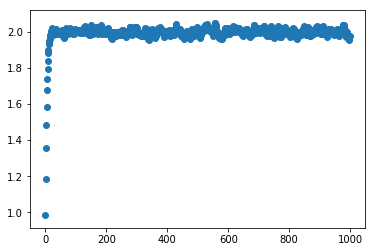

In [2]:
# テストデータ（AR(1)）

# データ生成時の時間総ステップ
original_T = 1000 

# AR(1)のパラメータ設定
phi0 = 0.4
phi1 = 0.8
mu = 0.
sigma = 0.01

# データ生成
def create_Y(T=original_T, phi0=phi0, phi1=phi1, mu=mu, sigma=sigma):
    Y = np.empty(T)
    epsilon = np.random.normal(loc=mu, scale=sigma, size=T)
    Y[0] = 1. + epsilon[0]
    for t in range(1,T):
        Y[t] = phi0 + phi1*Y[t-1] + epsilon[t]
    return Y
original_Y = create_Y()
print("データ数：", original_Y.shape)

# なんだかよくわからないAR(1)データ完成。プロットしてみる。
plt.scatter(range(original_T),original_Y)


### 1.2 テストデータを使った計算


### 定常性の条件
#### 1. 期待値は時刻に依存しない.すなわち $E(Y_t) = \mu$.
#### 2. 共分散は時刻に依存しない.すなわち $Cov(Y_t,Y_{t-h})$はhのみに依存する.

### 1.2.1 期待値

$$\begin{align*} Y_t &= \phi_0 + \phi_1Y_{t-1} + \epsilon_t\\
&= \phi_0(1 + \phi_1^1 + \cdots + \phi_1^{t-2}) + \phi_1^{t-1}Y_1 
+ \phi_1^{t-2}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1} + \epsilon_t\end{align*}$$
より

$$\begin{align*} E(Y_t) &= E(\phi_0 + \phi_1Y_{t-1} + \epsilon_t)\\
&= E(\phi_0(1 + \phi_1^1 + \cdots + \phi_1^{t-2}))
+ E(\phi_1^{t-1}Y_1)
+ E(\phi_1^{t-2}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1} + \epsilon_t)\\
&= \phi_0 \frac{1-\phi_1^{t-1}}{1-\phi_1}+ \phi_1^{t-1}
\end{align*}$$

この期待値が時刻によらない値となるためにはtが十分大きい必要がある。（たぶん）
今回のテストデータでは、時刻0付近ではかなり値が変動していることから、最初のほうのタイムステップの値を使わないこととする。
また、lagがtime step数に対して大きくなるとデータ数が減るせいか、結果がかなり暴れるので、ラグの上限値も別途決めることとする。

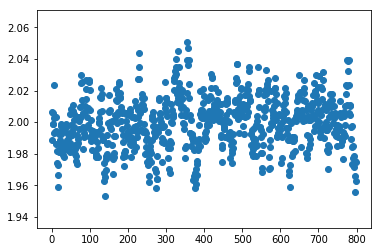

In [3]:
# 適当なところでデータを切断して使う。
first = 200 # firstより前の値は使わない
last = original_T
Y = original_Y[first:]
T = last - first # データ数
max_lag = 100 # lag上限値

plt.scatter(range(len(Y)), Y)

In [4]:
print("サンプル：", Y.mean())
print("理論値　：", phi0 * (1-phi1**float(T-1)) / (1-phi1) + phi1**float(T-1))

サンプル： 1.9995704879606535
理論値　： 2.0000000000000004


### 1.2.2 自己共分散

#### サンプルデータから計算

In [5]:
sample_cov = np.empty(max_lag)
for lag in range(max_lag):
    sample_cov[lag] = np.cov(Y[:T-lag], Y[lag:], ddof=1)[0, 1] # 分散共分散行列から共分散のみ取り出す
#print("サンプル：")
#print(sample_cov)

#### 理論式から計算

$$\begin{align*}
&Cov(Y_t,Y_{t-h})\\
&= Cov(\phi_0 + \phi_1Y_{t-1} + \epsilon_t, Y_{t-h})\\
&= Cov(\phi_0(1 + \phi_1^1 + \cdots + \phi_1^{t-2}) + \phi_1^{t-1}Y_1 
+ \phi_1^{t-2}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1} + \epsilon_t,\phi_0(1 + \phi_1^1 + \cdots + \phi_1^{t-2-h}) + \phi_1^{t-1-h}Y_1 
+ \phi_1^{t-2-h}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1-h} + \epsilon_{t-h})\\
&= Cov(\phi_1^{t-1}\epsilon_1 + \phi_1^{t-2}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1} + \epsilon_t ,\phi_1^{t-1-h}\epsilon_1 + \phi_1^{t-2-h}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1-h} + \epsilon_{t-h})\\
&= \phi_1^{2t-h-2}V(\epsilon_1) + \phi_1^{2t-h-4}V(\epsilon_2) + \cdots + \phi_1^{h+1}V(\epsilon_{t-h-1}) + \phi_1^{h}V(\epsilon_{t-h})\\
&= \phi_1^{2t-h-2}\sigma^2 + \phi_1^{2t-h-4}\sigma^2 + \cdots + \phi_1^{h+2}\sigma^2 + \phi_1^{h}\sigma^2\\
&= \frac{\sigma^2\phi_1^h(1-\phi_1^{2(t-h)})}{1-\phi_1^2}\\
\end{align*}$$

In [6]:
lag = np.arange(max_lag, dtype=float)
theoretical_cov = sigma**2 / (1-phi1**2) * (phi1**lag) * (1-phi1**(2*lag[::-1]))
#print("理論値　：")
#print(theoretical_cov)

#### 共分散の計算結果のプロット

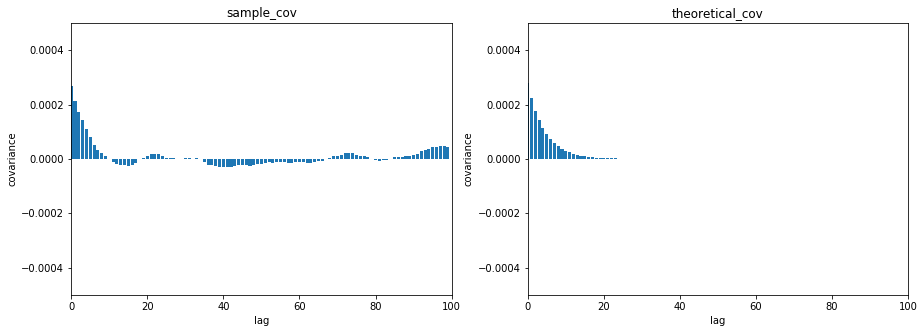

In [7]:
plt.figure(figsize=(15, 5))
titles = ["sample_cov","theoretical_cov"]
plot_val = [sample_cov, theoretical_cov]
for i in range(len(titles)):
    plt.subplot(1, 2, i+1)
    plt.bar(range(max_lag), plot_val[i])
    plt.title(titles[i])
    plt.xlabel('lag')
    plt.ylabel('covariance')
    plt.xlim([0, max_lag])
    plt.ylim(-5e-4, 5e-4)

### 1.2.3 自己相関（正規化する）

#### サンプルデータから計算

In [8]:
sample_rho = np.empty(max_lag)
for lag in range(max_lag):
    var1 = np.var(Y[lag:], ddof=1)
    var2 = np.var(Y[:T-lag], ddof=1)
    sample_rho[lag] = sample_cov[lag] / (var1*var2)**0.5
#plt.bar(range(max_lag),sample_rho)

In [9]:
# 検算
# sample_corrcoef = np.empty(max_lag)
# for lag in range(max_lag):
#     sample_corrcoef[lag] = np.corrcoef(Y[:T-lag], Y[lag:], ddof=1)[0, 1]
# plt.bar(range(max_lag), sample_corrcoef)

#### 理論式から計算

$$\begin{align*} V(Y_t) &= V(\phi_0 + \phi_1Y_{t-1} + \epsilon_t)\\
&= V(\phi_0(1 + \phi_1^1 + \cdots + \phi_1^{t-2})
+ \phi_1^{t-1}Y_1
+ \phi_1^{t-2}\epsilon_2 + \cdots + \phi_1^1\epsilon_{t-1} + \epsilon_t)\\
&= V(\phi_1^{t-1}\epsilon_1) + V(\phi_1^{t-2}\epsilon_2) + \cdots + V(\phi_1^1\epsilon_{t-1}) + V(\epsilon_t)\\
&=  \frac{\sigma^2(1-\phi_1^{2t})}{1-\phi_1^2}
\end{align*}$$

In [10]:
theoretical_var = sigma**2 / (1-phi1**2) # t→∞を仮定した値
theoretical_rho = np.empty(max_lag)
for lag in range(max_lag):
    theoretical_rho[lag] = theoretical_cov[lag] / theoretical_var
#plt.bar(range(max_lag), theoretical_rho)

#### 自己相関係数の計算結果のプロット

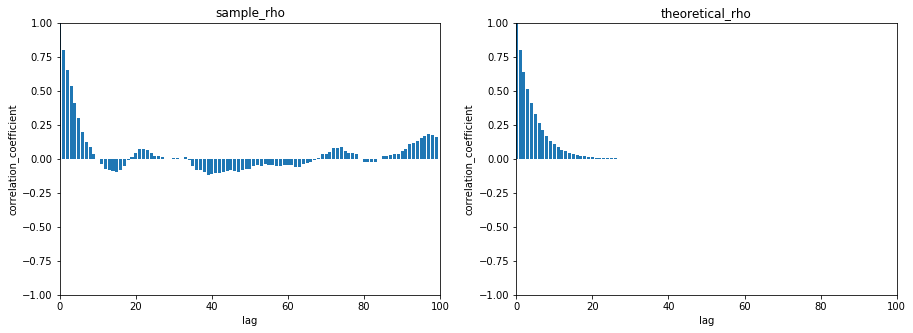

In [11]:
plt.figure(figsize=(15, 5))
titles = ["sample_rho","theoretical_rho"]
plot_val = [sample_rho, theoretical_rho]
for i in range(len(titles)):
    plt.subplot(1, 2, i+1)
    plt.bar(range(max_lag), plot_val[i])
    plt.title(titles[i])
    plt.xlabel('lag')
    plt.ylabel('correlation_coefficient')
    plt.xlim([0, max_lag])
    plt.ylim(-1,1)

### 1.2.4 偏自己相関係数

In [12]:
# データの形の確認
print(sample_rho.shape)
print(theoretical_rho.shape)

(100,)
(100,)


#### 偏自己相関係数は下記を満たす$\phi$として計算できる
$$
\left[\begin{array}{ccc}
1 & \rho(1) & \cdots & \rho(h-1) \\
\rho(1) & 1 & \cdots & \rho(h-2) \\
\vdots & \vdots & \ddots & \vdots \\
\rho(h-1) & \rho(h-2) & \cdots & 1 \\
\end{array}\right]
\left[\begin{array}{ccc}
\phi_1  \\
\phi_2 \\
\vdots \\
\phi_h \\
\end{array}\right]
=
\left[\begin{array}{ccc}
\rho(1)  \\
\rho(2) \\
\vdots \\
\rho(h) \\
\end{array}\right]
$$

In [13]:
# 上の式の左辺の行列と偏相関係数の定義
rho_list = [sample_rho, theoretical_rho]
Matrix_list = [np.eye(max_lag-1), np.eye(max_lag-1)] # 対角成分1で初期化
phi_list = []

# 偏相関係数の計算
for i in range(len(rho_list)):
    for lag in range(max_lag-1):
        Matrix_list[i][lag+1:, lag] = rho_list[i][1:max_lag-lag-1]
        Matrix_list[i][lag, lag+1:] = rho_list[i][1:max_lag-lag-1]
    phi_list.append( np.dot(np.linalg.inv(Matrix_list[i]), rho_list[i][1:]) ) # lag1以上について計算

# 値の表示
for i in range(len(rho_list)):
    if i == 0:
        print("*"*30 + "サンプル値" + "*"*50)
    else:
        print("*"*30 + "理論値" + "*"*50)
    print("行列")
    print(Matrix_list[i])
    print("偏相関係数")
    print(phi_list[i])

******************************サンプル値**************************************************
行列
[[1.     0.7986 0.6508 ... 0.1652 0.1801 0.1751]
 [0.7986 1.     0.7986 ... 0.1556 0.1652 0.1801]
 [0.6508 0.7986 1.     ... 0.1333 0.1556 0.1652]
 ...
 [0.1652 0.1556 0.1333 ... 1.     0.7986 0.6508]
 [0.1801 0.1652 0.1556 ... 0.7986 1.     0.7986]
 [0.1751 0.1801 0.1652 ... 0.6508 0.7986 1.    ]]
偏相関係数
[ 7.6514e-01  3.7754e-02  6.1936e-02 -2.5588e-02 -3.0405e-02 -3.2304e-02
 -3.6204e-02  7.4574e-02 -1.7308e-02  1.3044e-02 -4.0953e-02 -4.4029e-02
  3.1509e-02  1.2777e-02 -5.2403e-02  8.6401e-04  4.9768e-03  7.8080e-02
 -6.3461e-02  4.4087e-02  3.6228e-02 -8.5368e-03 -1.6342e-02 -2.5595e-02
 -4.7235e-02  3.3533e-02  3.2628e-02 -5.5196e-02  2.1631e-02  2.6024e-02
 -9.8067e-03 -6.0479e-02  1.4055e-01 -1.5644e-02 -5.8940e-02 -7.4767e-02
  8.4370e-02 -1.0142e-02 -6.4731e-02  4.5826e-02 -3.5934e-02  3.9145e-03
  1.5352e-02  5.3679e-04  4.3328e-02 -2.3630e-02 -7.7894e-02  4.9772e-02
  3.2612e-02 -5.0652e

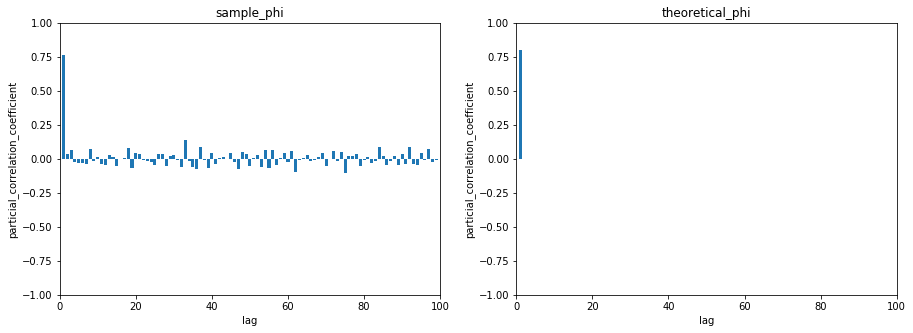

In [14]:
plt.figure(figsize=(15, 5))
titles = ["sample_phi","theoretical_phi"]
plot_val = phi_list
for i in range(len(titles)):
    plt.subplot(1, 2, i+1)
    plt.bar(range(1, plot_val[i].shape[0]+1), plot_val[i])
    plt.title(titles[i])
    plt.xlabel('lag')
    plt.ylabel('particial_correlation_coefficient')
    plt.xlim([0, max_lag])
    plt.ylim(-1,1)

#### AR(1)なので、$\rho(1)$のみ相関を持っているのは、たぶん正しい。

#### あとできることといえば、
$$
\rho_{YZ,X} = \frac{\rho_{YZ}-\rho_{XY}\rho_{XZ}}{sqrt(1-\rho_{XY}^2)sqrt(1-\rho_{XZ}^2)}\\
$$
#### と一致するかどうか確認したい。

## 2. 時系列データ分析のデータを使ってみる。